In [1]:
import pandas as pd
import numpy as np
import math
import os
import datetime

from scipy.spatial.distance import cdist
from scipy.fftpack import fft
from sklearn.manifold import MDS

import matplotlib.pyplot as plt
import matplotlib.cm as cm
plt.style.use('seaborn-whitegrid')
%matplotlib inline
plt.rcParams['figure.figsize'] = (6.0, 4.0) # set default size of plots
import matplotlib.pyplot as plt

from scipy.spatial.distance import pdist, squareform

In [2]:
# ## Mount Google drive folder
# from google.colab import drive
# drive.mount('/content/drive', force_remount = True)

In [3]:
# ## Setup working directory and data directory
# DIR = '/content/drive/MyDrive/Colab Notebooks/MAHE/MSIS Coursework/Miniprojects/Adil'
# os.chdir(DIR)

In [2]:
## Read data
df = pd.read_csv(r"C:\Users\ibner\Downloads\New folder\data.csv", sep=",", header=0)
df[['date', 'timestamp']] = df['time'].str.split('\s+', expand = True)
df.drop(['time'], axis = 1, inplace = True)
df['date'] =  pd.to_datetime(df['date'], format='%d-%m-%Y')
df['timestamp'] =  pd.to_datetime(df['timestamp'], format='%H:%M').dt.time
df.loc[:, (df.columns != 'date') & (df.columns != 'timestamp')] = df.loc[:, df.columns != 'date'].apply(pd.to_numeric, errors = 'coerce')
print(df.dtypes)
df.head(100)

Cyclone_Inlet_Gas_Temp             float64
Cyclone_Material_Temp              float64
Cyclone_Outlet_Gas_draft           float64
Cyclone_cone_draft                 float64
Cyclone_Gas_Outlet_Temp            float64
Cyclone_Inlet_Draft                float64
date                        datetime64[ns]
timestamp                           object
dtype: object


,Cyclone_Inlet_Gas_Temp,Cyclone_Material_Temp,Cyclone_Outlet_Gas_draft,Cyclone_cone_draft,Cyclone_Gas_Outlet_Temp,Cyclone_Inlet_Draft,date,timestamp
0,867.63,910.42,-189.54,-186.04,852.13,-145.90,2017-01-01,00:00:00
1,879.23,918.14,-184.33,-182.10,862.53,-149.76,2017-01-01,00:05:00
2,875.67,924.18,-181.26,-166.47,866.06,-145.01,2017-01-01,00:10:00
3,875.28,923.15,-179.15,-174.83,865.85,-142.82,2017-01-01,00:15:00
4,891.66,934.26,-178.32,-173.72,876.06,-143.39,2017-01-01,00:20:00
...,...,...,...,...,...,...,...,...
95,863.20,902.56,-172.64,-164.10,854.67,-142.92,2017-01-01,07:55:00
96,876.41,911.41,-175.91,-171.55,862.48,-144.66,2017-01-01,08:00:00
97,873.89,917.18,-172.26,-160.11,865.02,-138.29,2017-01-01,08:05:00
98,870.67,919.84,-177.01,-146.57,862.77,-143.80,2017-01-01,08:10:00


Text(0, 0.5, '% Missing Values')

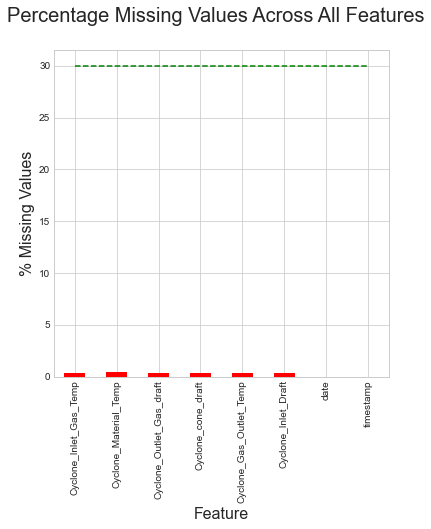

In [3]:
## Plot percentage of missing values (NaNs) for each feature
cutoff = 30
fig = plt.figure(figsize=(6, 6))
percent_missing = (df.isna().sum() / df.shape[0]) * 100
percent_missing.plot(kind = 'bar', color = cm.rainbow(np.linspace(0, 1, 2))[(percent_missing <= cutoff).values.astype(int)])
plt.plot(np.arange(df.shape[1]), np.repeat(cutoff, df.shape[1]), 'g--') 
fig.suptitle('Percentage Missing Values Across All Features', fontsize = 20)
plt.xlabel('Feature', fontsize = 16)
plt.ylabel('% Missing Values', fontsize = 16)

In [4]:
## Linear interpolation for all column
df['Cyclone_Inlet_Gas_Temp'] = df['Cyclone_Inlet_Gas_Temp'].interpolate(method = 'linear')
df["Cyclone_Material_Temp"] = df["Cyclone_Material_Temp"].interpolate(method='linear')
df["Cyclone_Outlet_Gas_draft"] = df["Cyclone_Outlet_Gas_draft"].interpolate(method='linear')
df["Cyclone_cone_draft"] = df["Cyclone_cone_draft"].interpolate(method='linear')
df["Cyclone_Gas_Outlet_Temp"] = df["Cyclone_Gas_Outlet_Temp"].interpolate(method='linear')
df["Cyclone_Inlet_Draft"] = df["Cyclone_Inlet_Draft"].interpolate(method='linear')
(df.isna().sum() / df.shape[0]) * 100


Cyclone_Inlet_Gas_Temp      0.0
Cyclone_Material_Temp       0.0
Cyclone_Outlet_Gas_draft    0.0
Cyclone_cone_draft          0.0
Cyclone_Gas_Outlet_Temp     0.0
Cyclone_Inlet_Draft         0.0
date                        0.0
timestamp                   0.0
dtype: float64

In [5]:
df

,Cyclone_Inlet_Gas_Temp,Cyclone_Material_Temp,Cyclone_Outlet_Gas_draft,Cyclone_cone_draft,Cyclone_Gas_Outlet_Temp,Cyclone_Inlet_Draft,date,timestamp
0,867.63,910.42,-189.54,-186.04,852.13,-145.90,2017-01-01,00:00:00
1,879.23,918.14,-184.33,-182.10,862.53,-149.76,2017-01-01,00:05:00
2,875.67,924.18,-181.26,-166.47,866.06,-145.01,2017-01-01,00:10:00
3,875.28,923.15,-179.15,-174.83,865.85,-142.82,2017-01-01,00:15:00
4,891.66,934.26,-178.32,-173.72,876.06,-143.39,2017-01-01,00:20:00
...,...,...,...,...,...,...,...,...
377714,899.42,919.79,-224.07,-209.77,901.01,-175.15,2020-08-07,11:55:00
377715,879.90,895.02,-228.04,-211.28,878.08,-176.94,2020-08-07,12:00:00
377716,887.20,895.70,-230.11,-214.65,885.32,-179.18,2020-08-07,12:05:00
377717,908.50,916.33,-231.51,-218.09,906.20,-181.96,2020-08-07,12:10:00


In [6]:
## Calculate FFT of each sample, followed by absolute value
## of Foruier coefficients and a pairwise distance between
## samples
fftval = df.groupby("date").apply(lambda x:  fft(x["Cyclone_Outlet_Gas_draft"].values))
#fftval = fftval[:-1].to_numpy()
fftval = np.array([x for x in fftval.values if len(x) == 288])
fftmag = np.abs(fftval)
dist = squareform(pdist(np.abs(fftmag), 'euclidean'))

In [7]:
dff = pd.DataFrame(dist)
dff

,0,1,2,3,4,5,6,7,8,9,...,1301,1302,1303,1304,1305,1306,1307,1308,1309,1310
0,0.000000,2002.805484,1734.344650,3840.106691,2682.251778,4947.371213,6635.458242,9314.067182,6138.702196,5723.538007,...,18823.772245,19307.530394,23241.088640,17700.366540,16957.898376,15602.139762,17910.748971,15602.451038,15004.003640,14775.605911
1,2002.805484,0.000000,797.109913,3310.084142,1074.898569,3276.850193,4974.170787,7628.852997,4355.137333,4020.121489,...,16996.865082,17478.939644,22981.105062,15887.058741,15121.666107,13816.722292,16143.872570,13793.624415,13211.576030,12997.759713
2,1734.344650,797.109913,0.000000,3230.213638,1298.974993,3517.073156,5215.128825,7899.480032,4658.369496,4316.257962,...,17340.239887,17823.090808,22886.982511,16227.208891,15449.337467,14129.485684,16458.340151,14118.310350,13551.025452,13307.841348
3,3840.106691,3310.084142,3230.213638,0.000000,3264.968017,3582.270791,4651.019059,6790.717192,4611.692364,4266.704723,...,16720.460366,17326.613517,20413.379387,15702.572610,14935.030864,13355.717741,15665.009752,13486.374018,12801.374087,12600.018132
4,2682.251778,1074.898569,1298.974993,3264.968017,0.000000,2698.286139,4469.590305,7055.220474,3800.527931,3540.430081,...,16396.624598,16883.866982,22784.112391,15297.630388,14506.321867,13206.232242,15566.476979,13189.113773,12608.609545,12419.268994
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1306,15602.139762,13816.722292,14129.485684,13355.717741,13206.232242,11004.425584,9258.327902,6987.345452,9610.222581,10006.826724,...,3763.868199,4455.098901,22332.983119,2977.645420,2970.063408,0.000000,2865.183272,1428.281698,2176.473271,1829.508933
1307,17910.748971,16143.872570,16458.340151,15665.009752,15566.476979,13386.565720,11504.764757,9254.797148,11956.653362,12287.831803,...,2824.531058,3227.142065,22990.183349,2205.922387,3495.720259,2865.183272,0.000000,3053.760495,3997.320016,3562.013662
1308,15602.451038,13793.624415,14118.310350,13486.374018,13189.113773,11028.141413,9321.606172,7131.997178,9620.166774,10043.410786,...,3628.473344,4126.686409,23029.972863,2655.858343,2659.131429,1428.281698,3053.760495,0.000000,2111.271601,1998.347283
1309,15004.003640,13211.576030,13551.025452,12801.374087,12608.609545,10373.003476,8842.708733,6609.259567,9056.449373,9526.535267,...,4385.951395,5019.821801,22880.657587,3643.301805,3240.799412,2176.473271,3997.320016,2111.271601,0.000000,2457.130963


In [8]:
radius=[]
for i in range(len(dff)):
    x=dff.sort_values(by=i, axis = 1).iloc[i:i+1,1:37]
    radius.append(x.iloc[:, -1].values)
radius

[array([1628.00682541]),
 array([1496.16702575]),
 array([1472.97216703]),
 array([2669.4446819]),
 array([1647.00731776]),
 array([2278.83353208]),
 array([2238.38501554]),
 array([2805.88813853]),
 array([1871.75667094]),
 array([1899.27849793]),
 array([1673.03439846]),
 array([1597.24273281]),
 array([1713.83364366]),
 array([1560.73604699]),
 array([1565.37719831]),
 array([2161.63781182]),
 array([2065.68381892]),
 array([1717.63283112]),
 array([3441.45473118]),
 array([2517.45144895]),
 array([1437.28200636]),
 array([4085.34239731]),
 array([19882.34787676]),
 array([1503.79562882]),
 array([9610.21886876]),
 array([12395.64275666]),
 array([1801.43064085]),
 array([4541.66325844]),
 array([1604.35312112]),
 array([1595.3418433]),
 array([1701.28186569]),
 array([4182.71177741]),
 array([1966.72683731]),
 array([1902.0045237]),
 array([1518.13737935]),
 array([1635.97643998]),
 array([1642.92457687]),
 array([1586.46443756]),
 array([4254.09202868]),
 array([2298.81373516]),
 

In [9]:
k = np.sqrt(dff.shape[0])
k = int(np.ceil(k))
k

37

In [10]:
df.tail()

,Cyclone_Inlet_Gas_Temp,Cyclone_Material_Temp,Cyclone_Outlet_Gas_draft,Cyclone_cone_draft,Cyclone_Gas_Outlet_Temp,Cyclone_Inlet_Draft,date,timestamp
377714,899.42,919.79,-224.07,-209.77,901.01,-175.15,2020-08-07,11:55:00
377715,879.90,895.02,-228.04,-211.28,878.08,-176.94,2020-08-07,12:00:00
377716,887.20,895.70,-230.11,-214.65,885.32,-179.18,2020-08-07,12:05:00
377717,908.50,916.33,-231.51,-218.09,906.20,-181.96,2020-08-07,12:10:00
377718,880.86,905.31,-235.02,-219.44,882.10,-184.02,2020-08-07,12:15:00


In [11]:
start = datetime.datetime(2017, 1, 1)
end = datetime.datetime(2020, 8, 7)
index = pd.date_range(start, end)
index
dfrad = pd.DataFrame(index, columns = ["date"])
dfrad

rad = pd.DataFrame(radius)

rad["yhat"]=(k/((math.pi)*(rad.iloc[:]**2)))

rad["probability"]=1-(rad["yhat"]/max(rad["yhat"]))

rad['Date'] = dfrad['date']


rad[['Date',"probability"]].head(50)

,Date,probability
0,2017-01-01,0.996179
1,2017-01-02,0.995476
2,2017-01-03,0.995333
3,2017-01-04,0.998579
4,2017-01-05,0.996267
5,2017-01-06,0.998050
6,2017-01-07,0.997979
7,2017-01-08,0.998714
8,2017-01-09,0.997110
9,2017-01-10,0.997193


In [12]:
result_outlier = rad[rad['probability'] > 0.999]
result_outlier

,0,yhat,probability,Date
18,3441.454731,9.944151e-07,0.999145,2017-01-19
21,4085.342397,7.056591e-07,0.999393,2017-01-22
22,19882.347877,2.979316e-08,0.999974,2017-01-23
24,9610.218869,1.275221e-07,0.999890,2017-01-25
25,12395.642757,7.665028e-08,0.999934,2017-01-26
...,...,...,...,...
1293,5446.057118,3.970886e-07,0.999659,2020-07-17
1294,7583.035538,2.048168e-07,0.999824,2020-07-18
1299,16465.905550,4.343908e-08,0.999963,2020-07-23
1300,3489.773324,9.670689e-07,0.999168,2020-07-24


In [13]:
result_not_ouliers = rad[rad['probability'] < 0.999]

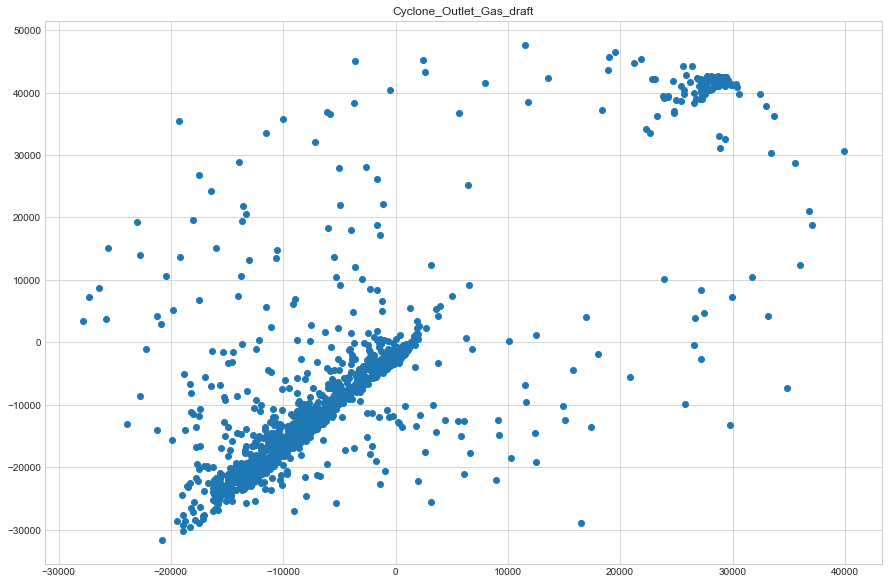

In [14]:
model = MDS(n_components=2, dissimilarity='precomputed', random_state=1)
mds_out = model.fit_transform(dist)
dates = df['date'].dt.date.values
x = mds_out[:,0]
y = mds_out[:,1]

plt.figure(figsize=(15,10))
plt.scatter(x,y)
# for i, txt in enumerate(dates):
#     try:
#         plt.annotate(txt, (x[i]+0.3, y[i]+0.3))
#     except:
#         continue
plt.title("Cyclone_Outlet_Gas_draft")
plt.show()

In [15]:
mds_out.shape

(1311, 2)

In [16]:
mds_out

array([[  1111.01147586,  -1283.4685868 ],
       [   180.8420596 ,  -2903.82057982],
       [   270.77292504,  -2543.43350738],
       ...,
       [ -8353.3813361 , -13824.9640559 ],
       [ -7563.64504738, -13542.45145362],
       [ -8220.5177628 , -12811.81003692]])

In [17]:
x.shape[0]

1311

In [18]:
# x1  = mds_out[result_less.index.values,0]
# print(x1.shape[0])
# # y = mds_out[~result_rad.index.values,1] 
# # plt.scatter(x, y)
# # plt.show()

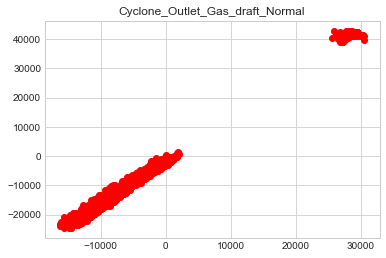

In [19]:
x_less = mds_out[result_not_ouliers.index.values,0]
y_less = mds_out[result_not_ouliers.index.values,1]

plt.title("Cyclone_Outlet_Gas_draft_Normal")
plt.scatter(x_less,y_less,c="red")
plt.show()

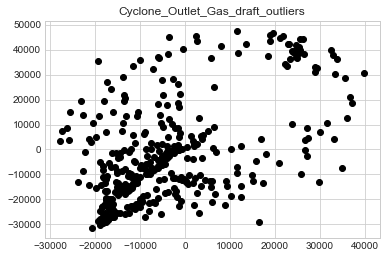

In [20]:
x_outlier = mds_out[result_outlier.index.values,0]
y_outlier = mds_out[result_outlier.index.values,1]

plt.title("Cyclone_Outlet_Gas_draft_outliers")
plt.scatter(x_outlier,y_outlier,c="black")
plt.show()

In [21]:
df_outlier_r = result_outlier.sample(n=5)

In [22]:
df_outlier_r

,0,yhat,probability,Date
824,10065.088543,1.162563e-07,0.999900,2019-04-05
986,8822.686749,1.513039e-07,0.999870,2019-09-14
1140,9774.868735,1.232622e-07,0.999894,2020-02-15
631,16430.740361,4.362522e-08,0.999962,2018-09-24
90,3322.192428,1.067093e-06,0.999082,2017-04-01
